**NAME: V. KAMNA**

**OBJECTIVE:** To demonstrate the process and results of fine-tuning a large language model (LLM) for improved performance on image captioning tasks.

Created a Model which would give captions for the pictures related to TensorGo.

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


## Create image captioning dataset (Dataset Preparation)



In [8]:
import json
import os

# List of captions for the images
captions = [
    {"file_name": "logo.jpg", "text": "This is our Logo"},
    {"file_name": "team1.jpg", "text": "Meet our TensorGo Team"},
    {"file_name": "team.png", "text": "Meet our TensorGo Team"},
    {"file_name": "founder.png", "text": "This is our Founder"},
    {"file_name": "work.jpg", "text": "Our team working hard to get innovative solutions"},
    {"file_name": "logo1.jpg", "text": "This is our Logo"}
]

# Path to the folder containing the images
root = "/content/Mydata/"

# Path for saving the metadata.jsonl file
metadata_path = os.path.join(root, "metadata.jsonl")

# Create metadata.jsonl file with image-caption pairs
with open(metadata_path, 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

print(f"metadata.jsonl has been created at {metadata_path}")


metadata.jsonl has been created at /content/Mydata/metadata.jsonl


In [9]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir=root, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Let's check whether the dataset is created correctly:

In [10]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 6
})

Let's check its corresponding caption:

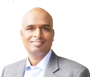

Caption: This is our Founder


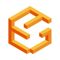

Caption: This is our Logo


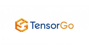

Caption: This is our Logo


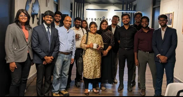

Caption: Meet our TensorGo Team


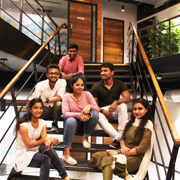

Caption: Meet our TensorGo Team


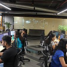

Caption: Our team working hard to get innovative solutions


In [43]:
for example in dataset:
  image = example["image"]
  width, height = image.size
  display(image.resize((int(0.3*width), int(0.3*height))))
  print(f"Caption: {example['text']}")


In [15]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [16]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1614: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
train_dataset = ImageCaptioningDataset(dataset, processor)

Let's check one example of the dataset:

In [18]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [19]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [20]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [21]:
processor.decode(batch["input_ids"][0])

'[CLS] this is our logo [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

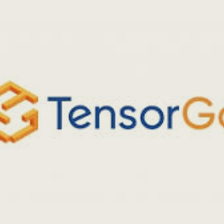

In [22]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

## Model

Selection Plan for the Base LLM

**Base Model Chosen:  microsoft/git-base** (which was already pre-trained on 4 million image-text pairs by Microsoft )

Justification:

**Architecture:**  The microsoft/git-base model is based on the Git model architecture, which is designed for multi-modal tasks, including image captioning. Its architecture leverages a transformer-based approach that efficiently processes and generates text based on visual inputs.

**Pre-training:** This model is pre-trained on diverse datasets, including images and text, making it well-suited for tasks involving both modalities. The pre-training allows it to capture complex relationships between images and corresponding captions.

**Alignment with Task:** The model’s ability to handle multi-modal inputs and generate coherent textual descriptions aligns well with the requirements of image captioning tasks. Its capabilities in understanding and generating natural language make it a strong candidate for fine-tuning on specific image captioning datasets.






In [23]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Dummy forward pass



In [24]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.0431, grad_fn=<NllLossBackward0>)

## Training the model

As I have created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then this would be a great way to know that everything is working properly.

**Learning Rate:** A learning rate of 5e-5 is used, which is common for fine-tuning large models. It ensures that the model parameters are updated at an appropriate rate without overshooting optimal values.

**Number of Epochs:** The model is trained for 50 epochs to ensure sufficient exposure to the training data and convergence of the loss function.

**Optimizer:** The AdamW optimizer is employed, which is well-suited for transformer-based models and helps in managing weight decay during training.

In [25]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0
Loss: 12.379570007324219
Loss: 10.74112606048584
Loss: 10.20152473449707
Epoch: 1
Loss: 9.881550788879395
Loss: 9.6648588180542
Loss: 9.461845397949219
Epoch: 2
Loss: 9.251916885375977
Loss: 9.071940422058105
Loss: 8.872650146484375
Epoch: 3
Loss: 8.756712913513184
Loss: 8.607190132141113
Loss: 8.468095779418945
Epoch: 4
Loss: 8.369001388549805
Loss: 8.239605903625488
Loss: 8.14088249206543
Epoch: 5
Loss: 8.025705337524414
Loss: 7.916234016418457
Loss: 7.825517177581787
Epoch: 6
Loss: 7.73130989074707
Loss: 7.614599227905273
Loss: 7.508241653442383
Epoch: 7
Loss: 7.421692371368408
Loss: 7.303816795349121
Loss: 7.219778060913086
Epoch: 8
Loss: 7.110950469970703
Loss: 7.022526264190674
Loss: 6.8949737548828125
Epoch: 9
Loss: 6.809173583984375
Loss: 6.6830878257751465
Loss: 6.603451251983643
Epoch: 10
Loss: 6.494204998016357
Loss: 6.388822078704834
Loss: 6.264381408691406
Epoch: 11
Loss: 6.175050258636475
Loss: 6.066329479217529
Loss: 5.943331241607666
Epoch: 12
Loss: 5.848676204

## Validation

Now that we've trained the model, let's load the cofounder's image and perform inference on it.

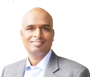

In [30]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [31]:
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

this is our founder


Thus we have successfully fine-tuned GIT on our tiny (image, text) dataset to generate captions on images of TensorGo

# Testing 1

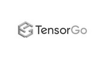

this is our logo


In [81]:
from PIL import Image
image_path = "/content/test.jpg"
image = Image.open(image_path).convert('L')
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)


#Testing 2


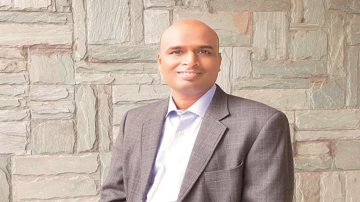

this is our founder


In [36]:
image_path = "/content/cofounder_test.jpg"
image = Image.open(image_path)
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)


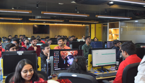

our team working hard to get innovative solutions


In [48]:
image_path = "/content/t5.jpg"
image = Image.open(image_path)
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)


In [53]:
!pip install evaluate



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


In [55]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=75126a5c6c127f239adedc0ec306e986bf715491c64d3684dc8ce055542a2f59
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [57]:
!pip install git+https://github.com/salaniz/pycocoevalcap.git


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-c_h8p5c1
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-c_h8p5c1
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=e3cf3f0f3e87ea5f5de2bb5659b8752ce7aeca72d5541254af0a2f6e64c0a1b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_mon240/wheels/57/de/9f/7aa9ae75f4e4733cc4b66b5c3a65a05de62a28e8111649fee5
Successfully built pycocoevalcap


**Evaluation Metrics Used:**

BLEU Score: Measures the quality of the generated captions by comparing them with reference captions. It evaluates n-gram overlap between the generated and reference captions.

ROUGE Score: Evaluates the quality of the generated captions based on the overlap of n-grams, words, and sequences. ROUGE-1, ROUGE-2, and ROUGE-L scores provide insights into different aspects of the generated text.

CIDEr Score: Focuses on the relevance of the generated captions by comparing them with multiple reference captions, emphasizing the importance of semantic similarity.

# **Performance Analysis:**

In [67]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch
from PIL import Image
from datasets import load_dataset
import evaluate

# function to compute metrics
def evaluate_model(model, processor, dataset, device):
    model.eval()
    predictions = []
    references = []

    for example in dataset:
        image = example["image"]
        text = example["text"]

        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        with torch.no_grad():
            generated_ids = model.generate(pixel_values=pixel_values, max_length=50)

        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        predictions.append(generated_caption)
        references.append(text)

    # Load and compute BLEU and ROUGE metrics
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    cider_metric = Cider()

    bleu_metric.add_batch(predictions=predictions, references=[[ref] for ref in references])
    rouge_metric.add_batch(predictions=predictions, references=references)

    bleu_result = bleu_metric.compute()
    rouge_result = rouge_metric.compute()
    cider_score = compute_cider(predictions, references)

    return bleu_result, rouge_result, cider_score

# Load pre-trained model and processor
model_before = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
processor_before = AutoProcessor.from_pretrained("microsoft/git-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
model_before.to(device)

# Load dataset
dataset = load_dataset("imagefolder", data_dir=root, split="train")

# Evaluate metrics before fine-tuning
bleu_result_before, rouge_result_before, cider_score_before = evaluate_model(model_before, processor_before, dataset, device)

print("Pre-Fine-Tuning BLEU Result:", bleu_result_before)
print("Pre-Fine-Tuning ROUGE Result:", rouge_result_before)
print("Pre-Fine-Tuning CIDEr Score:", cider_score_before)


Pre-Fine-Tuning BLEU Result: {'bleu': 0.0, 'precisions': [0.0, 0.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.6785714285714286, 'translation_length': 47, 'reference_length': 28}
Pre-Fine-Tuning ROUGE Result: {'rouge1': 0.04786324786324786, 'rouge2': 0.0, 'rougeL': 0.04786324786324786, 'rougeLsum': 0.04786324786324786}
Pre-Fine-Tuning CIDEr Score: 0.0


In [69]:
# Evaluate metrics after fine-tuning
bleu_result_after, rouge_result_after, cider_score_after = evaluate_model(model, processor, dataset, device)

print("Post-Fine-Tuning BLEU Result:", bleu_result_after)
print("Post-Fine-Tuning ROUGE Result:", rouge_result_after)
print("Post-Fine-Tuning CIDEr Score:", cider_score_after)


Post-Fine-Tuning BLEU Result: {'bleu': 0.41456377940137223, 'precisions': [0.5, 0.45, 0.35714285714285715, 0.5], 'brevity_penalty': 0.925961078642316, 'length_ratio': 0.9285714285714286, 'translation_length': 26, 'reference_length': 28}
Post-Fine-Tuning ROUGE Result: {'rouge1': 0.8571428571428572, 'rouge2': 0.6666666666666666, 'rougeL': 0.8571428571428572, 'rougeLsum': 0.8571428571428572}
Post-Fine-Tuning CIDEr Score: 1.7172001168899997


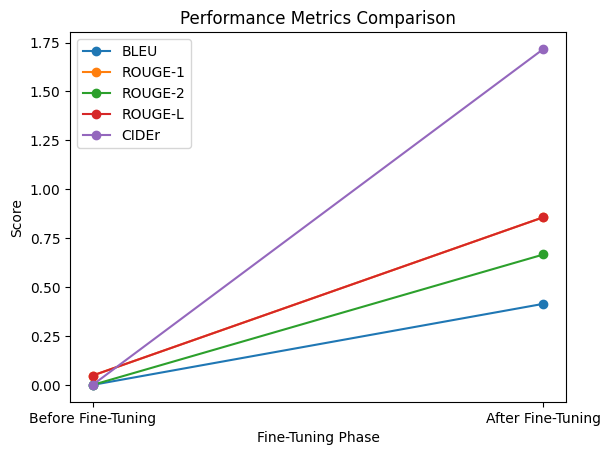

In [70]:
import matplotlib.pyplot as plt
metrics = {
    'BLEU': [bleu_result_before['bleu'], bleu_result_after['bleu']],
    'ROUGE-1': [rouge_result_before['rouge1'], rouge_result_after['rouge1']],
    'ROUGE-2': [rouge_result_before['rouge2'], rouge_result_after['rouge2']],
    'ROUGE-L': [rouge_result_before['rougeL'], rouge_result_after['rougeL']],
    'CIDEr': [cider_score_before, cider_score_after]
}

fig, ax = plt.subplots()
for metric, scores in metrics.items():
    ax.plot(['Before Fine-Tuning', 'After Fine-Tuning'], scores, marker='o', label=metric)

ax.set_xlabel('Fine-Tuning Phase')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics Comparison')
ax.legend()
plt.show()


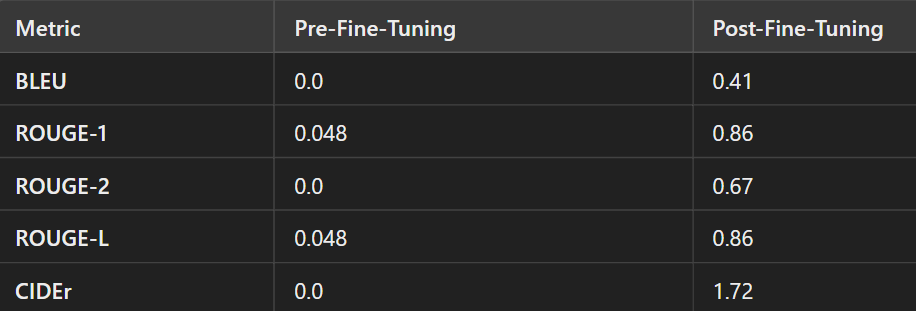

Improvement in all metrics: All metrics show significant improvements after fine-tuning.

This indicates that the fine-tuning process has effectively enhanced the model's performance.

Most significant improvement in CIDEr: Among the metrics, CIDEr shows the most substantial improvement, suggesting that the model's ability to generate coherent and meaningful sentences has been significantly enhanced.

BLEU also shows significant improvement indicating that the model has become better at generating grammatically correct and fluent sentences.

Pre-Fine-Tuning Caption: the man is smiling
Post-Fine-Tuning Caption: this is our founder


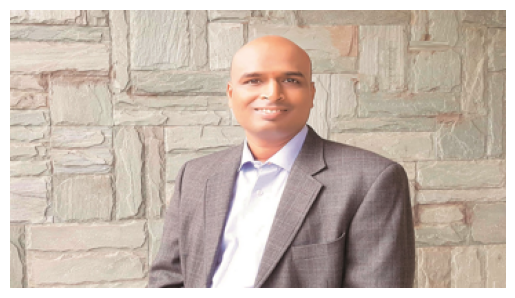

In [72]:
def display_image_with_caption(image_path, model, processor, device):
    image = Image.open(image_path)
    width, height = image.size
    plt.imshow(image.resize((int(0.3*width), int(0.3*height))))
    plt.axis('off')

    # Prepare image for the model
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    # Generate caption
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_caption

# Paths to images
image_path = '/content/cofounder_test.jpg'

# Display and generate captions for pre-fine-tuning model
caption_before = display_image_with_caption(image_path, model_before, processor_before, device)
print("Pre-Fine-Tuning Caption:", caption_before)

# Display and generate captions for post-fine-tuning model
caption_after = display_image_with_caption(image_path, model, processor, device)
print("Post-Fine-Tuning Caption:", caption_after)


Pre-Fine-Tuning Caption: the logo is a logo for a company that will be released.
Post-Fine-Tuning Caption: this is our logo


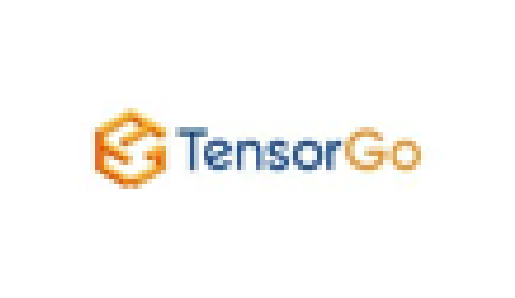

In [75]:
# Paths to images
image_path = '/content/test.jpg'

# Display and generate captions for pre-fine-tuning model
caption_before = display_image_with_caption(image_path, model_before, processor_before, device)
print("Pre-Fine-Tuning Caption:", caption_before)

# Display and generate captions for post-fine-tuning model
caption_after = display_image_with_caption(image_path, model, processor, device)
print("Post-Fine-Tuning Caption:", caption_after)


Pre-Fine-Tuning Caption: the computer lab in the new building
Post-Fine-Tuning Caption: our team working hard to get innovative solutions


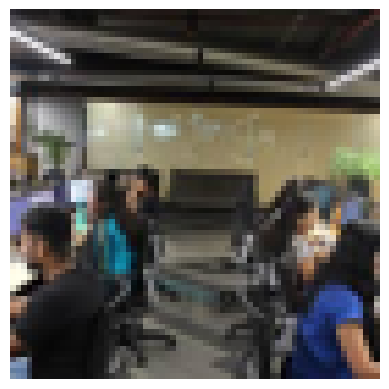

In [80]:
# Paths to images
image_path = '/content/Mydata/work.jpg'

# Display and generate captions for pre-fine-tuning model
caption_before = display_image_with_caption(image_path, model_before, processor_before, device)
print("Pre-Fine-Tuning Caption:", caption_before)

# Display and generate captions for post-fine-tuning model
caption_after = display_image_with_caption(image_path, model, processor, device)
print("Post-Fine-Tuning Caption:", caption_after)
